In [131]:
#pip install TextBlob

In [2]:
# Import required libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
import re
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abhishek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abhishek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhishek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load Datasets
true_data = pd.read_csv('True.csv', encoding='ISO-8859-1', on_bad_lines='skip')
fake_data = pd.read_csv('Fake.csv', encoding='ISO-8859-1', on_bad_lines='skip')
print("True Data\n",true_data.head(),"\n")
print("Fake Data\n",fake_data.head())

True Data
                                                title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017    

Fake Data
                                                title  \
0   Donald Trump S

In [5]:
true_data.shape, fake_data.shape   # Checking shape of dataset

((21416, 4), (23481, 4))

In [44]:
fake_data.info(), true_data.info()   # Checking Dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23471 entries, 0 to 23470
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23471 non-null  object
 1   text     23471 non-null  object
 2   subject  23471 non-null  object
 3   date     23471 non-null  object
 4   label    23471 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21406 entries, 0 to 21405
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21406 non-null  object
 1   text     21406 non-null  object
 2   subject  21406 non-null  object
 3   date     21406 non-null  object
 4   label    21406 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.3+ KB


(None, None)

In [7]:
# Add a label column
true_data['label'] = 1  # True news
fake_data['label'] = 0  # Fake news

In [8]:
# Manual Testing Splits and Row Removal
fake_data_manual_testing = fake_data.tail(10)
for i in range(23480,23470,-1):
    fake_data.drop([i], axis = 0, inplace = True)

true_data_manual_testing = true_data.tail(10)
for i in range(21415,21405,-1):
    true_data.drop([i], axis = 0, inplace = True)   

In [9]:
# Adding Labels to Manual Testing Data
true_data_manual_testing['label'] = 1  # True news
fake_data_manual_testing['label'] = 0  # Fake news

In [10]:
# Combine the datasets
data = pd.concat([true_data, fake_data], ignore_index=True)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44877 entries, 0 to 44876
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44877 non-null  object
 1   text     44877 non-null  object
 2   subject  44877 non-null  object
 3   date     44877 non-null  object
 4   label    44877 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [12]:
data.describe()

,label
count,44877.000000
mean,0.476993
std,0.499476
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [14]:
data['subject'].value_counts()

subject
politicsNews       11271
worldnews          10135
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          768
Name: count, dtype: int64

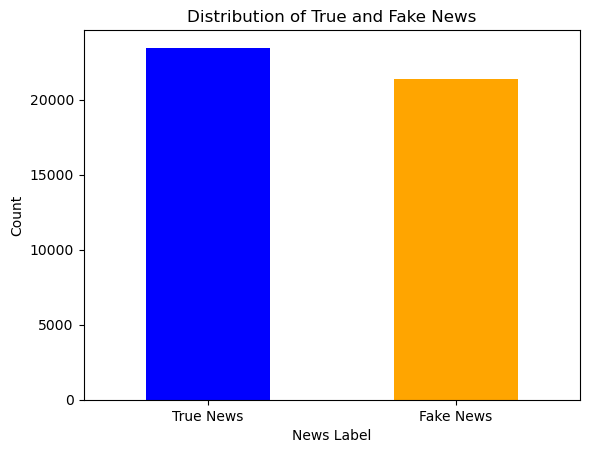

In [15]:
# Bar plot with different colors for each bar
bar_colors = ['Blue', 'Orange']  # Blue for True news, Orange for Fake news
data.groupby(['label'])['text'].count().plot(kind="bar", color=bar_colors)

# Adding labels and title
plt.title('Distribution of True and Fake News')
plt.xlabel('News Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['True News', 'Fake News'], rotation=0)
plt.show()


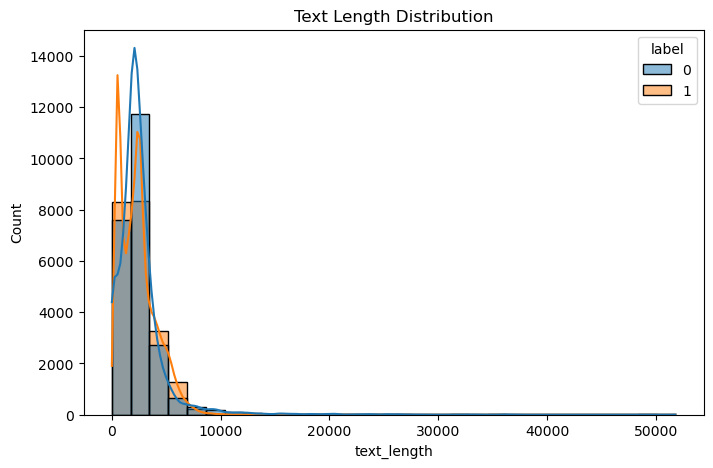

In [16]:
# Text length analysis
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='text_length', hue='label', bins=30, kde=True)
plt.title("Text Length Distribution")
plt.show()

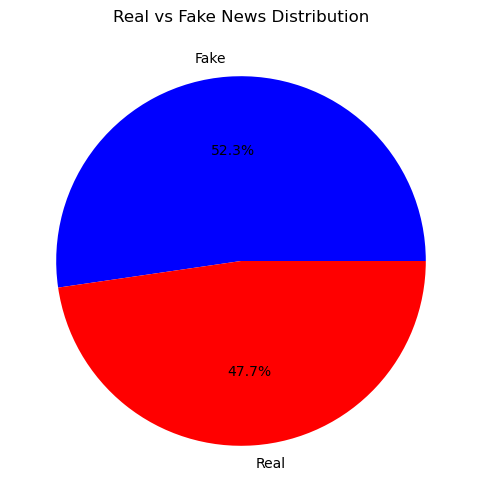

In [17]:
# Pie chart of label distribution
label_counts = data['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['Fake', 'Real'], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title('Real vs Fake News Distribution')
plt.show()

In [18]:
#Sentiment Analysis
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['sentiment'] = data['text'].apply(calculate_sentiment)

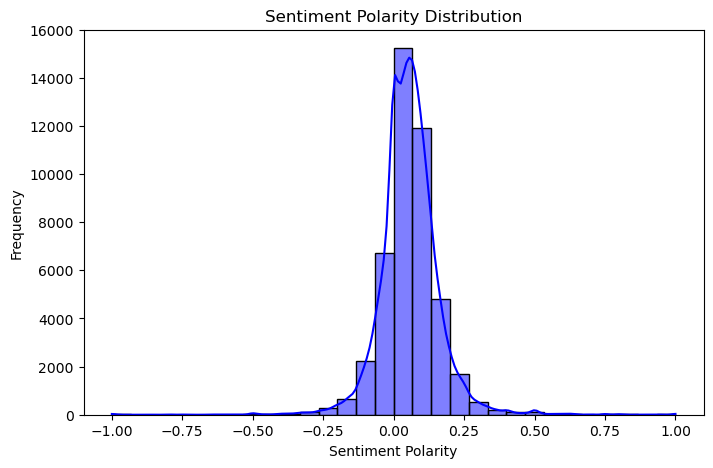

In [19]:
# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['sentiment'], bins=30, kde=True, color='blue')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [20]:
def plot_top_ngrams(corpus, n = 2, top_n = 20):
    vec = CountVectorizer(ngram_range = (n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns = ['Ngram', 'Frequecy'])
    sns.barplot(y = 'Ngram', x = 'Frequecy', data=ngram_df, palette='viridis', color = 'blue')
    plt.title(f'Top {top_n} {n}-grams')
    plt.show()

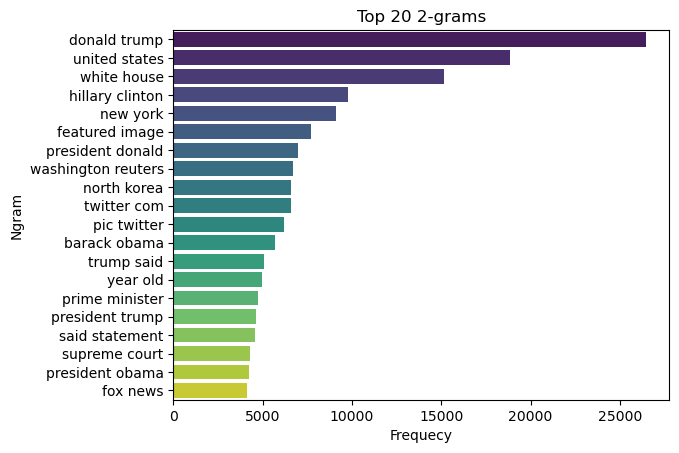

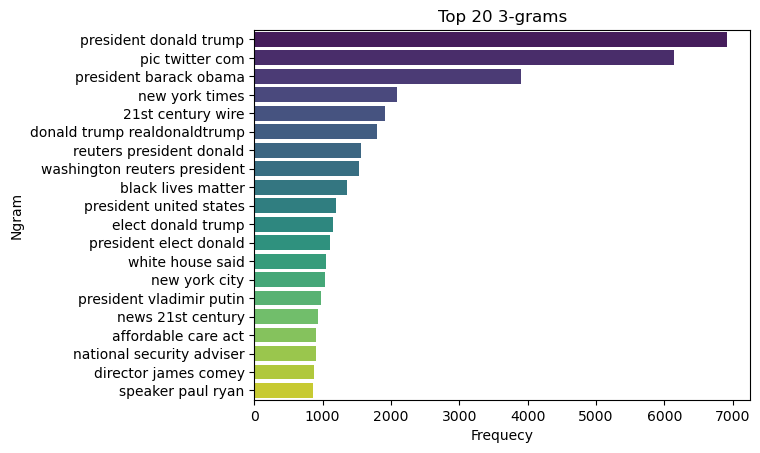

In [21]:
plot_top_ngrams(data['text'], n = 2, top_n = 20)
plot_top_ngrams(data['text'], n = 3, top_n = 20)

In [22]:
# WordClouds for Real and Fake News
real_text = ' '.join(data[data['label'] == 1]['text'])
fake_text = ' '.join(data[data['label'] == 0]['text'])

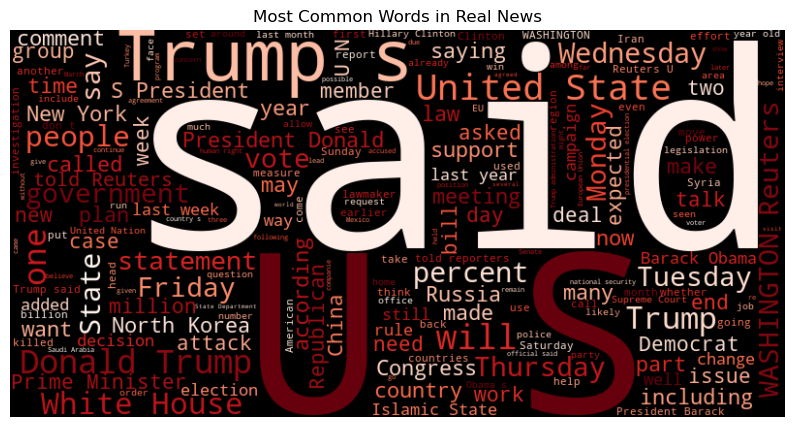

In [23]:
# WordCloud for real news
plt.figure(figsize=(10, 6))
wordcloud_real = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Real News')
plt.show()

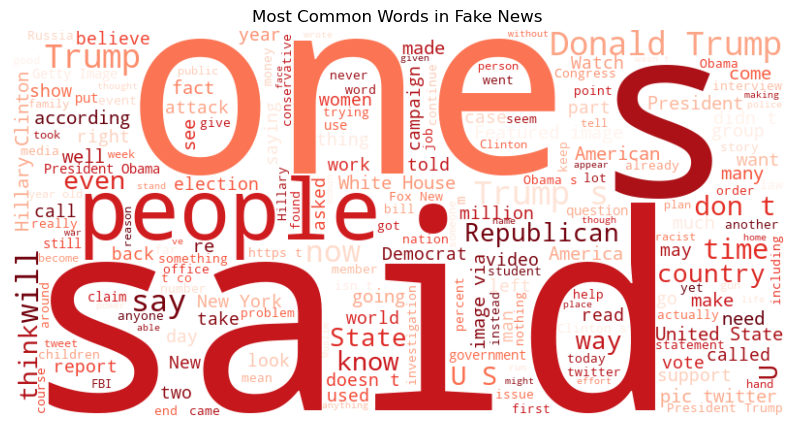

In [24]:
# WordCloud for fake news
plt.figure(figsize=(10, 6))
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Fake News')
plt.show()

# -> Data Preprocessing

In [25]:
# Initialize stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [26]:
# Function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply cleaning function
data['clean_text'] = data['text'].apply(clean_text)

In [27]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)
    
data['clean_text'] = data['clean_text'].apply(remove_stopwords)

In [28]:
# Function to apply stemming
def apply_stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

data['clean_text'] = data['clean_text'].apply(apply_stemming)

In [29]:
# Function to apply lemmatization
def apply_lemmatization(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
    
data['clean_text'] = data['clean_text'].apply(apply_lemmatization)

In [30]:
# Data Preparation
X = data['clean_text']
y = data['label']

In [31]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [33]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
log_reg_pred = log_reg.predict(X_test_tfidf)

print("Logistic Regression Performance:")
print(classification_report(y_test, log_reg_pred))
print(f"Accuracy: {accuracy_score(y_test, log_reg_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, log_reg_pred)}\n")

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4661
           1       0.98      0.99      0.99      4315

    accuracy                           0.99      8976
   macro avg       0.99      0.99      0.99      8976
weighted avg       0.99      0.99      0.99      8976

Accuracy: 0.9868538324420677
ROC-AUC: 0.9869632956887145



In [34]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)

print("Naive Bayes Performance:")
print(classification_report(y_test, nb_pred))
print(f"Accuracy: {accuracy_score(y_test, nb_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, nb_pred)}\n")

Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4661
           1       0.93      0.92      0.93      4315

    accuracy                           0.93      8976
   macro avg       0.93      0.93      0.93      8976
weighted avg       0.93      0.93      0.93      8976

Accuracy: 0.9285873440285205
ROC-AUC: 0.9283391461358185



In [35]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred))
print(f"Accuracy: {accuracy_score(y_test, rf_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_pred)}\n")

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4661
           1       1.00      1.00      1.00      4315

    accuracy                           1.00      8976
   macro avg       1.00      1.00      1.00      8976
weighted avg       1.00      1.00      1.00      8976

Accuracy: 0.9975490196078431
ROC-AUC: 0.9975453723023546



In [36]:
# Define and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)

# Evaluate the model (Optional)
dt_pred = dt_model.predict(X_test_tfidf)
print("Decision Tree Performance:")
print(classification_report(y_test, dt_pred))
print(f"Accuracy: {accuracy_score(y_test, dt_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_pred)}\n")

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4661
           1       1.00      0.99      0.99      4315

    accuracy                           0.99      8976
   macro avg       0.99      0.99      0.99      8976
weighted avg       0.99      0.99      0.99      8976

Accuracy: 0.9948752228163993
ROC-AUC: 0.9947987827297988



In [37]:
# Neural Network Model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(X_train_tfidf, y_train)
nn_pred = nn_model.predict(X_test_tfidf)

print("Neural Network Performance:")
print(classification_report(y_test, nn_pred))
print(f"Accuracy: {accuracy_score(y_test, nn_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, nn_pred)}\n")

Neural Network Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4661
           1       0.99      0.99      0.99      4315

    accuracy                           0.99      8976
   macro avg       0.99      0.99      0.99      8976
weighted avg       0.99      0.99      0.99      8976

Accuracy: 0.991198752228164
ROC-AUC: 0.9910437264120338



In [38]:
# Combine results into a DataFrame with actual model scores
results_df = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Accuracy': accuracy_score(y_test, log_reg_pred), 'ROC-AUC': roc_auc_score(y_test, log_reg_pred)},
    {'Model': 'Naive Bayes', 'Accuracy': accuracy_score(y_test, nb_pred), 'ROC-AUC': roc_auc_score(y_test, nb_pred)},
    {'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, rf_pred), 'ROC-AUC': roc_auc_score(y_test, rf_pred)},
    {'Model': 'Decision Tree', 'Accuracy': accuracy_score(y_test, dt_pred), 'ROC-AUC': roc_auc_score(y_test, dt_pred)},
    {'Model': 'Neural Network', 'Accuracy': accuracy_score(y_test, nn_pred), 'ROC-AUC': roc_auc_score(y_test, nn_pred)}
])

print(results_df)


                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.986854  0.986963
1          Naive Bayes  0.928587  0.928339
2        Random Forest  0.997549  0.997545
3        Decision Tree  0.994875  0.994799
4       Neural Network  0.991199  0.991044


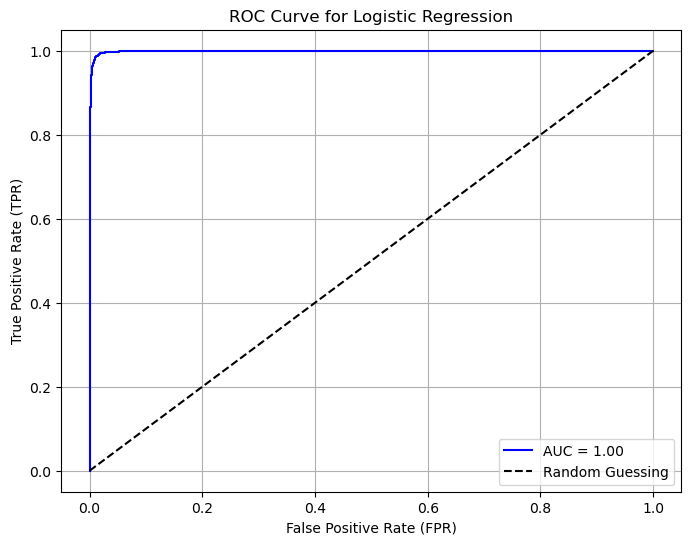

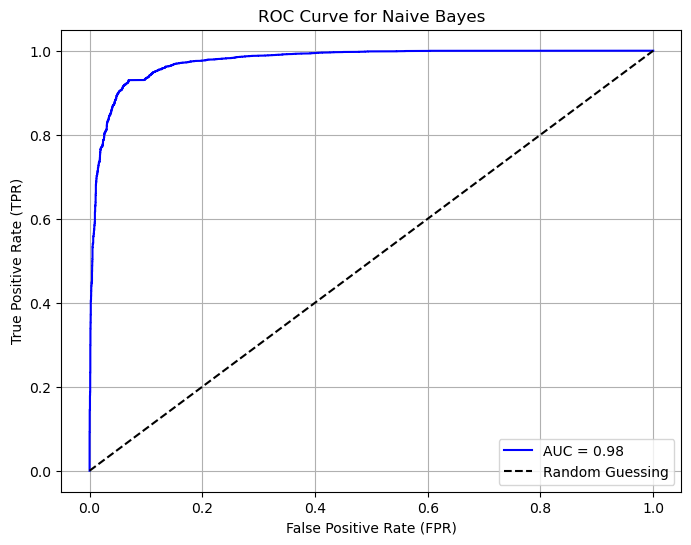

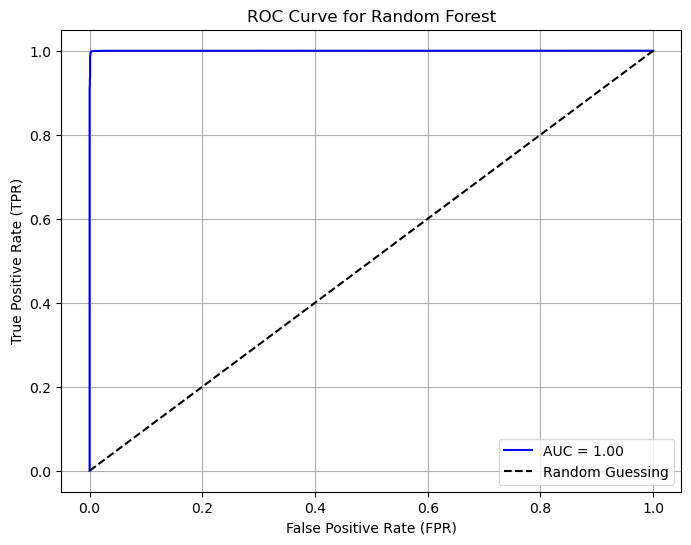

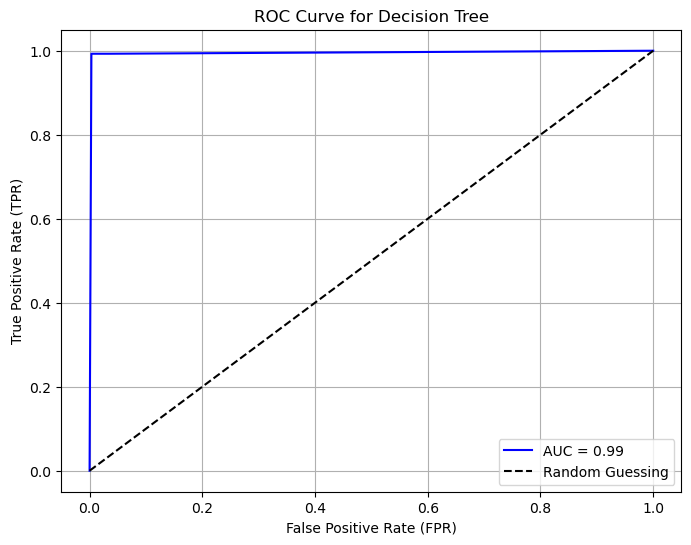

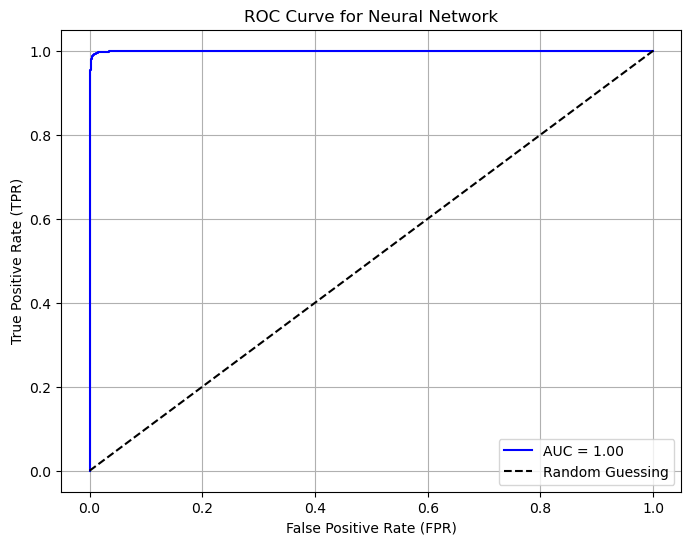

In [39]:
# Dictionary of models for ROC Curve plotting
models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Neural Network": nn_model
}

# Plot ROC Curve for each model individually
for model_name, model in models.items():
    # Get probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    
    # Add labels, title, legend, and grid
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

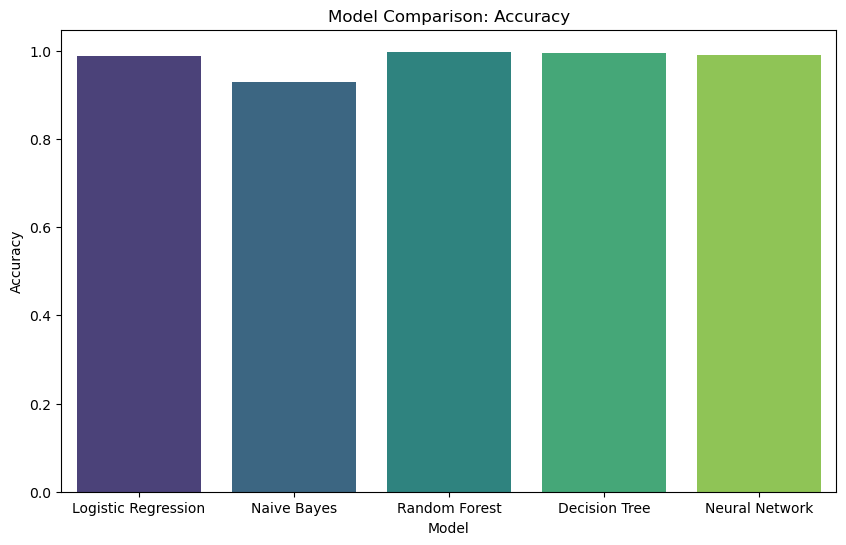

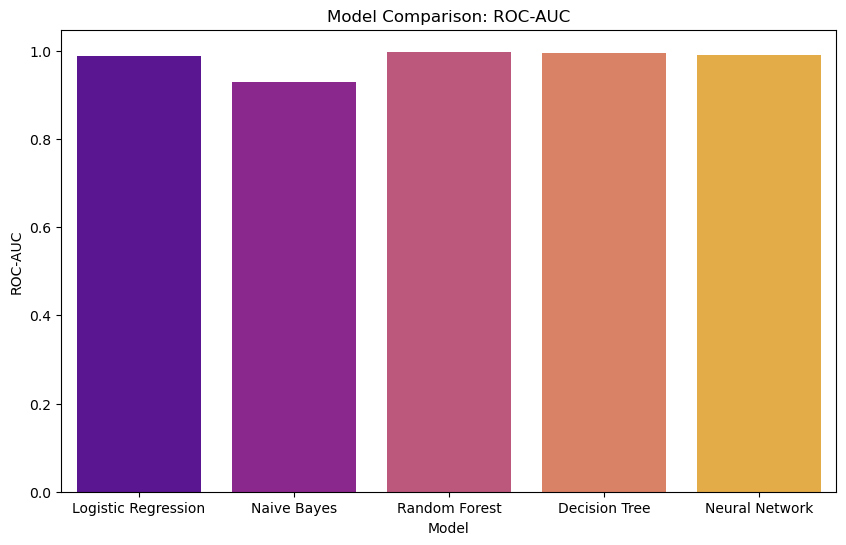

In [40]:
# Comparie all models
# Visualize results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Comparison: Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='plasma')
plt.title('Model Comparison: ROC-AUC')
plt.show()

                     Accuracy   ROC-AUC
Logistic Regression  0.986854  0.986963
Naive Bayes          0.928587  0.928339
Random Forest        0.997549  0.997545
Decision Tree        0.994875  0.994799
Neural Network       0.991199  0.991044


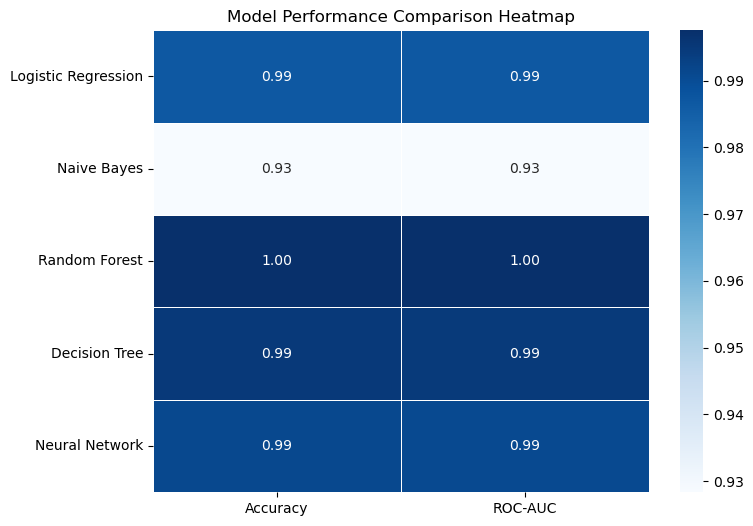

In [41]:
# Create a DataFrame with accuracy, ROC-AUC, and other metrics for each model
performance_metrics = {
    "Accuracy": [
        accuracy_score(y_test, log_reg_pred),
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, nn_pred)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, log_reg_pred),
        roc_auc_score(y_test, nb_pred),
        roc_auc_score(y_test, rf_pred),
        roc_auc_score(y_test, dt_pred),
        roc_auc_score(y_test, nn_pred)
    ]
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_metrics, index=['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Decision Tree', 'Neural Network'])
print(metrics_df)
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap='Blues', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Model Performance Comparison Heatmap')
plt.show()


In [45]:
import pickle

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Save Logistic Regression Model
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(log_reg, file)

# Save Naive Bayes Model
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)

# Save Random Forest Model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save Decision Tree Model
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

# Save Neural Network Model
with open('neural_network_model.pkl', 'wb') as file:
    pickle.dump(nn_model, file)

print("All models and vectorizer saved successfully!")

All models and vectorizer saved successfully!
